### Determine if user texting behaviour has changed. 
### Uses Bayeian Inference 

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import theano.tensor as tt
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(11, 9)

In [2]:
data = pd.read_csv("SMS Data.csv", header=None)
data.reset_index(inplace=True)
data.columns = ['Day', "SMS_Count"]
data.head()

,Day,SMS_Count
0,0,13
1,1,24
2,2,8
3,3,24
4,4,7


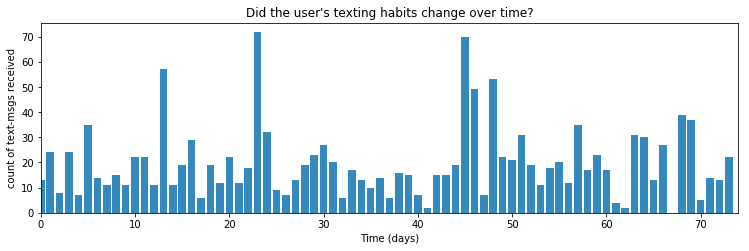

In [3]:
figsize(12.5, 3.5)
n_count_data = data.shape[0]
plt.bar(np.arange(n_count_data), data.SMS_Count, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [28]:
sms_mean = data.SMS_Count.mean()

#### Problem Setting:
How can we start to model this? Poisson random variable is a very appropriate model for this type of count data. Denoting day $i$'s text-message count by $C_i$,

$$ C_i \sim \text{Poisson}(\lambda)  $$
We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a switchpoint:

$$
\lambda = 
\begin{cases}
\lambda_1  &amp; \text{if } t \lt \tau \cr
\lambda_2 &amp; \text{if } t \ge \tau
\end{cases}
$$
If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the exponential distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

$$\begin{align}
&amp;\lambda_1 \sim \text{Exp}( \alpha ) \\\
&amp;\lambda_2 \sim \text{Exp}( \alpha )
\end{align}$$
$\alpha$ is called a hyper-parameter or parent variable. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$

In [60]:
#Initialization of Pirors. 
#Assumption: There is only 1 change in behaviour
with pm.Model() as model:
    alpha = 1.0/data.SMS_Count.mean() #Rate for exponentail distribution

    lambda_1 = pm.Exponential("lambda_1",alpha) #Poission rate of period 1 
    lambda_2 = pm.Exponential("lambda_2",alpha) #Poission rate of period 2
    tau = pm.DiscreteUniform("tau",lower=0, upper=n_count_data-1) 

In [61]:
#Create a new function lambda_
with model:
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [62]:
#Combines our data with  proposed data-generation scheme
with model:
    obs = pm.Poisson("obs", lambda_, observed=data.SMS_Count)

In [63]:
# Sample from Posterior Distribution
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 60000/60000 [00:29<00:00, 2011.04draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [64]:
#Extract samples from posterior
lambda_1_sample = trace['lambda_1']
lambda_2_sample = trace['lambda_2']
tau_sample = trace['tau']

E:\AnacondaNew\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


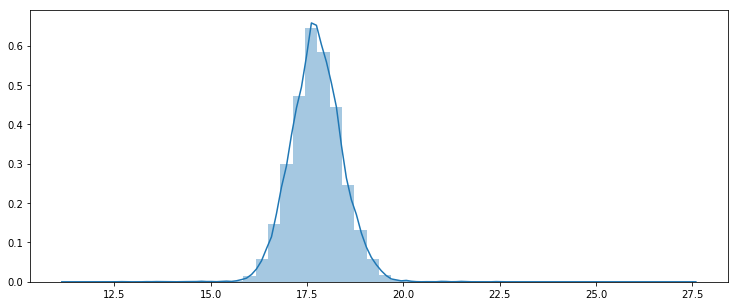

In [65]:
sns.distplot(lambda_1_sample)

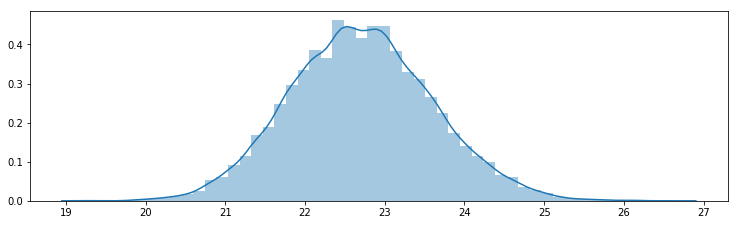

In [45]:
sns.distplot(lambda_2_sample)

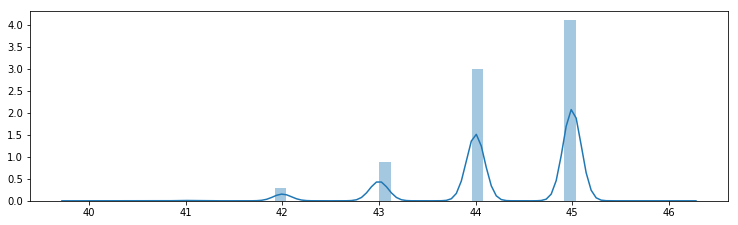

In [46]:
sns.distplot(tau_sample)

In [47]:
#Z-Score of 2 distributions
Z = (lambda_2_sample.mean() - lambda_1_sample.mean())/ np.sqrt(lambda_1_sample.std()**2 + lambda_2_sample.std()**2 ) 
print("Z Score is:", Z)

Z Score is: 4.4962569095592855


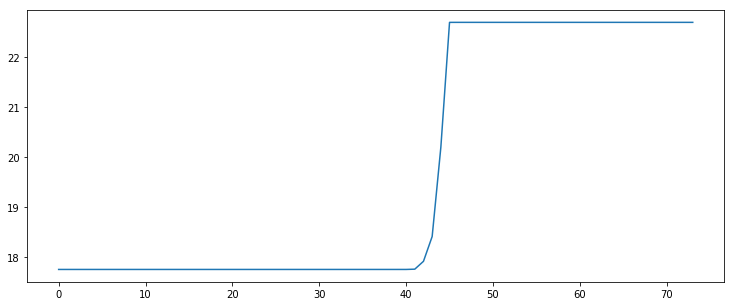

In [56]:
#Expected number of SMS per day

figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_sample.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0,n_count_data):
    ix = day < tau_sample
    expected_texts_per_day[day] = (lambda_1_sample[ix].sum() + lambda_2_sample[~ix].sum()) / N
sns.lineplot(data=expected_texts_per_day)

In [67]:
expected_texts_per_day[:44].mean()




17.77122103652412

In [66]:
lambda_1_sample.mean()

17.74597618435463